In [34]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
from MaSS import MaSS
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [35]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
# Hyper-parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.005

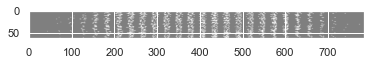

In [37]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [38]:
class FCNClass(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        #activation = self.outputLayer(output)
        return output


In [39]:
class FCNClass_batch1(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass_batch1, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)

        
        self.normised = nn.BatchNorm1d(num_features=10)


    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        output   = self.output(midLevel)
        normised = self.normised(output)
        
        return normised


In [40]:
class FCNClass_batch2(nn.Module):
    def __init__(self):
        # input: 784 Dimensional Vectors as input
        super(FCNClass_batch2, self).__init__()

        # layer 1 (784-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden1 = nn.Sequential(
                        nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 2 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden2 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )

        # Layer 3 (100-100)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.hidden3 = nn.Sequential(
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        
        self.normised = nn.BatchNorm1d(num_features=100)

        # Layer 4 (100-10)
        # Hidden Layer
        # Dropout Layer with keep prob 0.5
        self.output = nn.Sequential(
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Dropout(p=0.5)
        )
        
        
        # 10 softmax activated output neurons
        self.outputLayer = nn.Softmax(dim=1)
        

    def forward(self, x):
        midLevel = self.hidden1(x)
        midLevel = self.hidden2(midLevel)
        midLevel = self.hidden3(midLevel)
        normised = self.normised(midLevel)
        output   = self.output(normised)
        return output


In [41]:
#model = FCNClass().to(device)
#model = FCNClass_batch1().to(device) # not great based on initial test
model = FCNClass_batch2().to(device)
ModelName = 'FCNBatchNorm'

criterion = nn.CrossEntropyLoss()
#optimizer = MaSS(model.parameters(), lr=learning_rate, alpha=0.05, kappa_t=3)
#optimizer = torch.optim.SGD( model.parameters(), momentum = 0.9, lr=learning_rate, nesterov = True,)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
opt = "Adam" # sgd,  nesterov and mass


In [42]:
epochs = []
n_total_steps = len(train_loader)
train_loss_average = torch.zeros(num_epochs)
valid_loss_average = torch.zeros(num_epochs)
train_accuracy = torch.zeros(num_epochs)
valid_accuracy = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)


In [43]:

def train():

    model.train()
    running_train_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        train_step_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_step_loss.backward()
        optimizer.step()

        running_train_loss += train_step_loss.item()

        #predictions
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the training losses and accuracies
    train_loss_average[epoch] = running_train_loss/len(train_loader)
    train_accuracy[epoch] = accuracy

    print(f'Training Loss: {running_train_loss/len(train_loader)}\t \
            Training accuracy: {train_accuracy[epoch]}')


In [44]:
def test():
    model.eval()

    running_valid_loss = 0
    correct = 0
    total = 0

    #validation loop
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            valid_step_loss = criterion(outputs, labels)

            running_valid_loss += valid_step_loss.item()

            #predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.*correct/total

    #get the validation losses
    valid_loss_average[epoch] = running_valid_loss/len(test_loader)
    valid_accuracy[epoch] = accuracy


    print(f'Validation Loss: {running_valid_loss/len(test_loader)}\t \
            Validation accuracy: {valid_accuracy[epoch]}\t \
            LR:{curr_lr}')

In [45]:
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')

    #get the current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    train()
    test()

    epochs.append(epoch)



    #step the learning rate scheduler
    scheduler.step()


print("--- %s seconds ---" % (time.time() - start_time))
print('Finished Training')


Epoch: 1
Training Loss: 1.7159433484331632	             Training accuracy: 40.83333206176758
Validation Loss: 0.7712938250250118	             Validation accuracy: 91.0199966430664	             LR:0.005
Epoch: 2
Training Loss: 1.4845546361352844	             Training accuracy: 48.150001525878906
Validation Loss: 0.6757687742163421	             Validation accuracy: 92.48999786376953	             LR:0.005
Epoch: 3
Training Loss: 1.4491012494828401	             Training accuracy: 49.099998474121094
Validation Loss: 0.6247022260146536	             Validation accuracy: 93.20999908447266	             LR:0.005
Epoch: 4
Training Loss: 1.439804152702726	             Training accuracy: 48.94166564941406
Validation Loss: 0.6150397381205468	             Validation accuracy: 93.26000213623047	             LR:0.005
Epoch: 5
Training Loss: 1.4213691650550249	             Training accuracy: 49.538333892822266
Validation Loss: 0.5991331331289498	             Validation accuracy: 93.80999755859375	      

In [46]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')



Accuracy of the network on the 10000 test images: 96.21 %


In [47]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig(title + '.png')

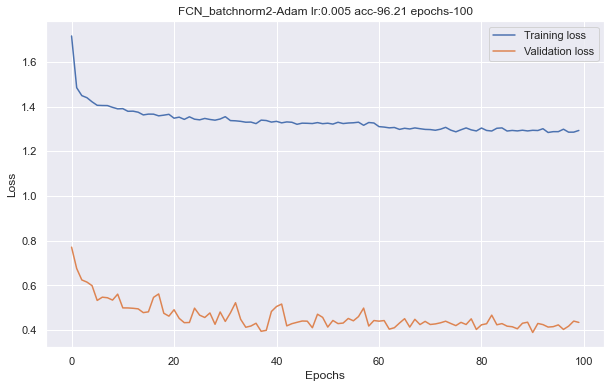

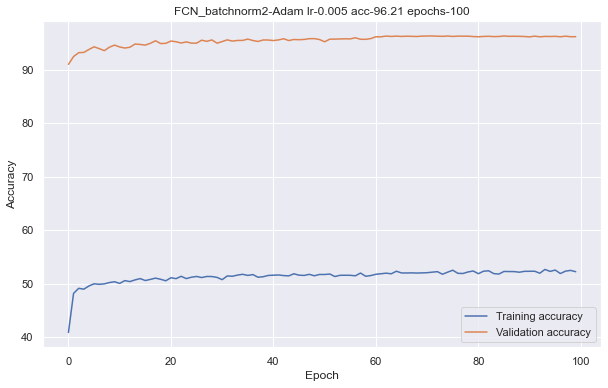

In [48]:

#plot combo loss diagrams
plt.figure(figsize=(10,6))
#plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc:{acc} epochs-{num_epochs}') #-mac
plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc-{acc} epochs-{num_epochs}') #-Win

plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.savefig(f'FCN_batchnorm2-Loss-{opt} lr:{learning_rate} acc:{acc}.png' epochs-{num_epochs}) #-mac
plt.savefig(f'FCN_batchnorm2-Loss-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}.png') #-win

#plot validation accuracies
plt.figure(figsize=(10,6))
#plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc:{acc} epochs-{num_epochs}') #-mac
plt.title(f'FCN_batchnorm2-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}') #-win
plt.plot(epochs, train_accuracy, label = "Training accuracy")
plt.plot(epochs, valid_accuracy, label = 'Validation accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.savefig(f'FCN_batchnorm2-Accuracy-{opt} lr:{learning_rate} acc:{acc}.png' epochs-{num_epochs}) #-mac
plt.savefig(f'FCN_batchnorm2-Accuracy-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}.png') #-win


#PATH = f'./FCN_batchnorm2-{opt}-lr:{learning_rate}-acc:{acc} epochs-{num_epochs}.pth' #-mac
PATH = f'./FCN_batchnorm2-{opt}-lr-{learning_rate}-acc-{acc} epochs-{num_epochs}.pth' #-win

torch.save(model.state_dict(), PATH)

In [49]:
train_loss_average.tolist()


[1.7159433364868164,
 1.484554648399353,
 1.449101209640503,
 1.439804196357727,
 1.421369194984436,
 1.4057847261428833,
 1.4048625230789185,
 1.404550552368164,
 1.396597146987915,
 1.3898993730545044,
 1.390846848487854,
 1.3790209293365479,
 1.3795952796936035,
 1.374894618988037,
 1.3627991676330566,
 1.366389513015747,
 1.3661600351333618,
 1.3586422204971313,
 1.3617329597473145,
 1.3654758930206299,
 1.3481746912002563,
 1.3527886867523193,
 1.3427939414978027,
 1.3543421030044556,
 1.3436689376831055,
 1.3408160209655762,
 1.3470642566680908,
 1.3424513339996338,
 1.339269995689392,
 1.3445576429367065,
 1.3549004793167114,
 1.3374598026275635,
 1.3363877534866333,
 1.3340678215026855,
 1.3301663398742676,
 1.330766201019287,
 1.323887586593628,
 1.339508056640625,
 1.3377268314361572,
 1.3307119607925415,
 1.333998680114746,
 1.3272992372512817,
 1.331495761871338,
 1.329869270324707,
 1.3208973407745361,
 1.3259167671203613,
 1.3253443241119385,
 1.324213981628418,
 1.328387

In [51]:
from pathlib import Path

df = pd.DataFrame(train_loss_average.tolist(), columns=['train_loss'], index=[i for i in range(1,epochs+1)])
filepath = Path(f'ResultsData/trainloss/test{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(valid_loss_average.tolist(), columns=['valid_loss'], index=[i for i in range(1,epochs+1)])
filepath = Path(f'ResultsData/validloss/test{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(train_accuracy.tolist(), columns=['train_accuracy'], index=[i for i in range(1,epochs+1)])
filepath = Path(f'ResultsData/trainacc/test{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

df = pd.DataFrame(valid_accuracy.tolist(), columns=['valid_accuracy'], index=[i for i in range(1,epochs+1)])
filepath = Path(f'ResultsData/validacc/test{ModelName}-{opt}-{learning_rate}-{acc}.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

TypeError: can only concatenate list (not "int") to list

In [ ]:
#plot the loss diagrams
#mac
#plotLosses(epochs, train_loss_average, f'FCN_batchnorm2-{opt}_train_loss lr:{learning_rate} acc:{acc} epochs-{num_epochs}')
#plotLosses(epochs, valid_loss_average, f'FCN_batchnorm2-{opt}_valid_loss lr:{learning_rate} acc:{acc} epochs-{num_epochs}')
#win
plotLosses(epochs, train_loss_average, f'FCN_batchnorm2-{opt}_train_loss lr-{learning_rate} acc-{acc} epochs-{num_epochs}')
plotLosses(epochs, valid_loss_average, f'FCN_batchnorm2-{opt}_valid_loss lr-{learning_rate} acc-{acc} epochs-{num_epochs}')

#plot combo loss diagrams
plt.figure(figsize=(10,6))
#plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc:{acc} epochs-{num_epochs}') #-mac
plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc-{acc} epochs-{num_epochs}') #-Win

plt.plot(epochs, train_loss_average, label = "Training loss")
plt.plot(epochs, valid_loss_average, label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.savefig(f'FCN_batchnorm2-Loss-{opt} lr:{learning_rate} acc:{acc}.png' epochs-{num_epochs}) #-mac
plt.savefig(f'FCN_batchnorm2-Loss-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}.png') #-win

#plot validation accuracies
plt.figure(figsize=(10,6))
#plt.title(f'FCN_batchnorm2-{opt} lr:{learning_rate} acc:{acc} epochs-{num_epochs}') #-mac
plt.title(f'FCN_batchnorm2-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}') #-win
plt.plot(epochs, train_accuracy, label = "Training accuracy")
plt.plot(epochs, valid_accuracy, label = 'Validation accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.savefig(f'FCN_batchnorm2-Accuracy-{opt} lr:{learning_rate} acc:{acc}.png' epochs-{num_epochs}) #-mac
plt.savefig(f'FCN_batchnorm2-Accuracy-{opt} lr-{learning_rate} acc-{acc} epochs-{num_epochs}.png') #-win


#PATH = f'./FCN_batchnorm2-{opt}-lr:{learning_rate}-acc:{acc} epochs-{num_epochs}.pth' #-mac
PATH = f'./FCN_batchnorm2-{opt}-lr-{learning_rate}-acc-{acc} epochs-{num_epochs}.pth' #-win

torch.save(model.state_dict(), PATH)